# Customer churn prediction

The goal of this project is to find insights about features and choose the best machine learning classification algorithm to predict churn better.

Source: [kaggle.com/datasets/shrutimechlearn/churn-modelling](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling)

## Import packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from visualization import *
from woe_transformation import *
from evaluation import *

import time
start_time = time.time()

## Load dataset

In [2]:
df = pd.read_csv('data/churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Checking duplicated rows:

In [6]:
len(df.loc[df.duplicated()])

0

Checking whitespaces and missing values:

In [7]:
for col in df.select_dtypes(include='object').columns.tolist():

        if df.loc[df[col].apply(lambda x: x.isspace())].empty == False:
                print(f'{col} has {len(df.loc[df[col].apply(lambda x: x.isspace())])} rows with only space characters. It will be replaced by NaN.')
                df.loc[df[col].apply(lambda x: x.isspace()), col] = np.nan
                df[col] = df[col].astype(float)

In [8]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Exploratory Data Analysis

In [9]:
X = df.drop(['RowNumber','CustomerId','Surname','Exited'], axis=1)
y = df['Exited']

Create barplots for categorical features:

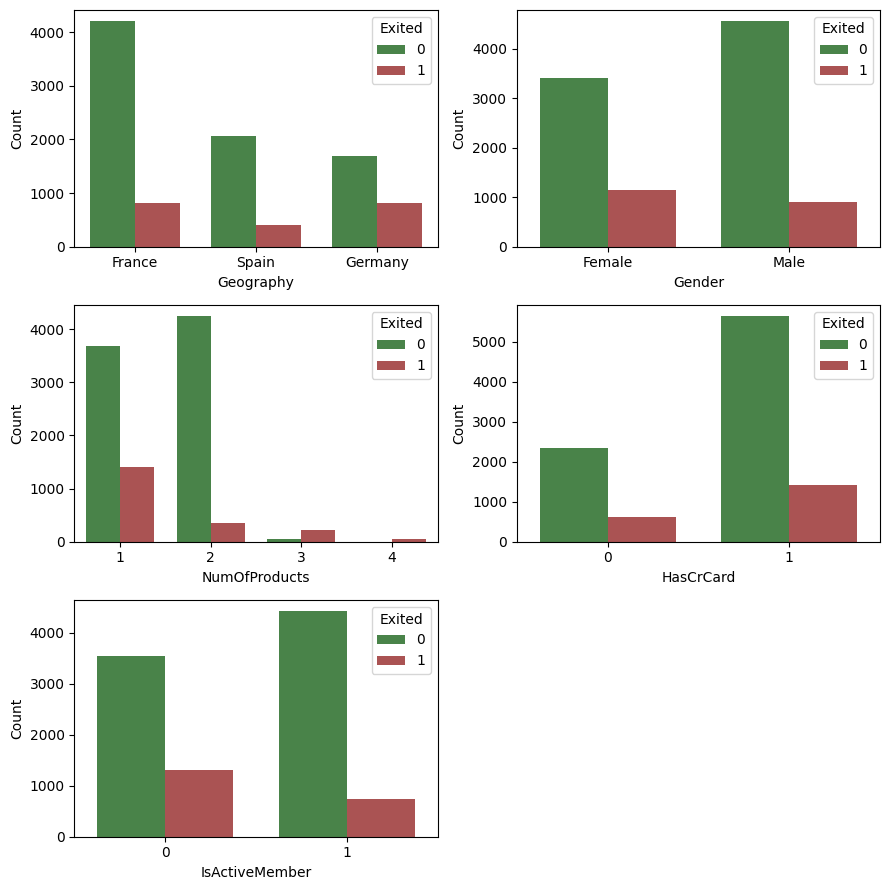

In [10]:
plot_categories(df, X.columns[X.nunique() < 10].tolist(), 'Exited')

* Clients from Spain are less likely to leave the bank.
* Less products can lead higher change of churn.
* Having a credit card is a significant indicator of churn.

Create histograms for numerical features:

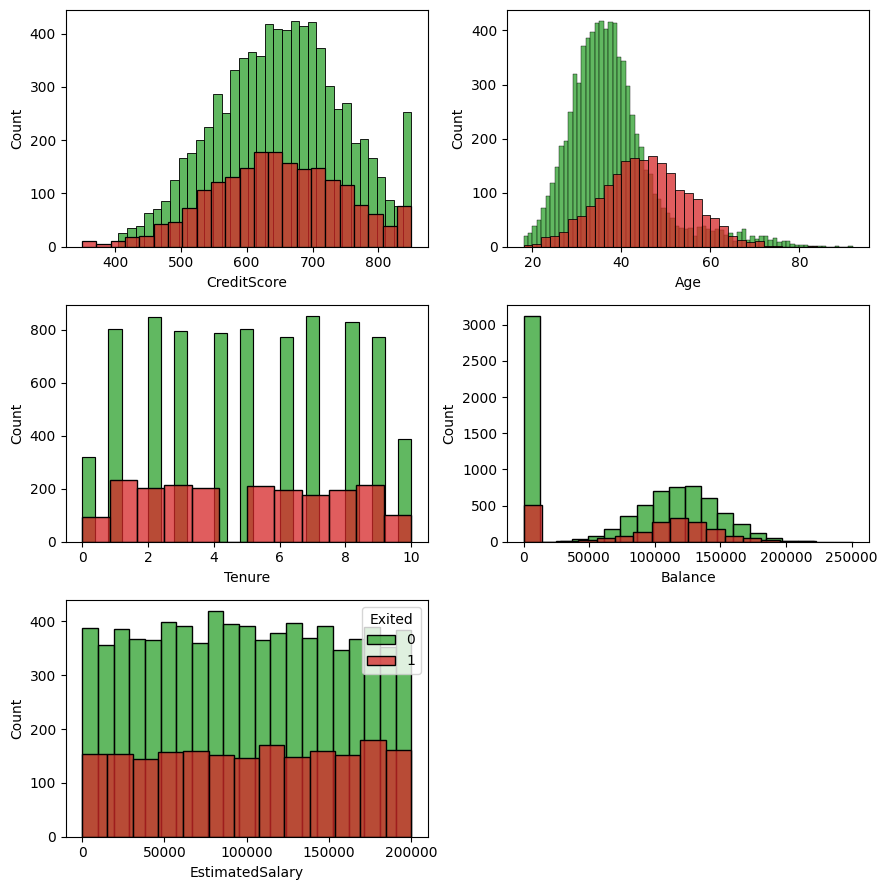

In [11]:
plot_histograms(df, X.columns[X.nunique() >= 10].tolist(), 'Exited')

* Distribution of age is significantly different for exited and non-exited population. Exited clients are older (40-50 years old) than non-exited clients (35-40 years old).

## Feature engineering

Create some new features from the existing ones:

In [12]:
X['HasJustCreditCard'] = np.where((X['NumOfProducts'] == 1) & (X['HasCrCard'] == 1), 1, 0)
X['BalanceDivByEstSalary'] = X['Balance'] / X['EstimatedSalary']
X['ActiveScore'] = X['IsActiveMember'] * X['CreditScore']

### Create dummy features

In [13]:
dummy = OneHotEncoder(drop='first')

numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [14]:
pd.DataFrame(dummy.fit_transform(X[categorical_features]).toarray(),
             columns=dummy.get_feature_names_out(), index=X.index).shape[1]

3

In [15]:
X = pd.concat([X, pd.DataFrame(dummy.fit_transform(X[categorical_features]).toarray(),
             columns=dummy.get_feature_names_out(), index=X.index)], axis=1).copy()

dummy_features = X.columns.tolist()[-3:]

### Train-test splitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f'Number of observations in train sample: {X_train.shape[0]}')
print(f'Churn rate in train sample: {round(y_train.mean(),4)}')
print(f'Number of observations in test sample: {X_test.shape[0]}')
print(f'Churn rate in test sample: {round(y_train.mean(),4)}')

Number of observations in train sample: 8000
Churn rate in train sample: 0.2037
Number of observations in test sample: 2000
Churn rate in test sample: 0.2037


### Create Weight of Evidence-transformed features

The weight of evidence shows the predictive power of a feature in connection with the target.<br/>
In credit risk modelling it is a measure of the separation of defaulted and non-defaulted clients.

**Fine classing** is the first step where the goal is to create equally-sized bins for numerical features, if it is possible.<br/>
Here 10 bins will be created for all of the features.<br/>
(Dummy features are not used in this transformation, because categorical features will be handled by using weight of evidences of the original categories.)

*Each step will be stored in the X_train_tmp object after applying transform methods.*

In [17]:
fine_classing = FineClassing()

fine_classing.fit(X_train[numerical_features+categorical_features], y_train)
X_train_tmp = fine_classing.transform(X_train)
X_train_tmp.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,HasJustCreditCard,BalanceDivByEstSalary,ActiveScore,Geography_Germany,Geography_Spain,Gender_Male
2151,8,2,1,9,7,0,0,1,0,8,1,0,0,-1,-1,-1
8392,8,0,1,2,3,2,0,1,0,3,1,4,0,-1,-1,-1
5006,8,0,0,4,0,3,1,1,1,5,0,3,5,-1,-1,-1
4117,1,2,1,4,5,0,1,1,0,4,0,0,0,-1,-1,-1
7182,6,0,1,8,6,3,1,0,1,5,0,3,4,-1,-1,-1


Keep only those features where the Information Value is greater than 0.05:

In [18]:
fine_classing.fine_iv_gini.sort_values(by='iv', ascending=False)

,feature_name,iv,gini
4,NumOfProducts,1.32789,0.167217
1,Age,0.76643,0.456947
11,Geography,0.18536,0.201313
6,IsActiveMember,0.14560,0.188958
10,ActiveScore,0.14462,0.194684
3,Balance,0.10670,0.146315
8,HasJustCreditCard,0.10477,0.158132
9,BalanceDivByEstSalary,0.09491,0.139226
12,Gender,0.06892,0.130867
0,CreditScore,0.01478,0.040761


In [19]:
filter_by_iv = FilterByInformationValue(iv_threshold=0.05)

filter_by_iv.fit(X_train_tmp, y_train)
X_train_tmp = filter_by_iv.transform(X_train_tmp)
X_train_tmp.head()

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,HasJustCreditCard,BalanceDivByEstSalary,ActiveScore
2151,2,1,9,0,0,0,1,0,0
8392,0,1,2,2,0,0,1,4,0
5006,0,0,4,3,1,1,0,3,5
4117,2,1,4,0,1,0,0,0,0
7182,0,1,8,3,1,1,0,3,4


**Coarse classing** is the next step of the process where the goal is to merge adjacent bins of the previously created categorical features.

The maximum number of groups could be 5, but the algorithm is choosing the best version for all features; highest information value where the order of the bins should be monotonous. Then the group labels will be replaced to the corresponding weight of evidence values.

In [20]:
coarse_classing = CoarseClassing()

coarse_classing.fit(X_train_tmp, y_train)
X_train_tmp = coarse_classing.transform(X_train_tmp)
X_train_tmp.head()

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,HasJustCreditCard,BalanceDivByEstSalary,ActiveScore
2151,0.30246,0.25823,-1.02864,0.41387,-0.41749,-0.35282,-0.39493,0.40846,-0.33516
8392,-0.65788,0.25823,0.96086,-0.26707,-0.41749,-0.35282,-0.39493,-0.22486,-0.33516
5006,-0.65788,-0.26846,0.73616,-0.26707,0.58318,0.41774,0.26762,-0.22486,0.53192
4117,0.30246,0.25823,0.73616,0.41387,0.58318,-0.35282,0.26762,0.40846,-0.33516
7182,-0.65788,0.25823,-1.02864,-0.26707,0.58318,0.41774,0.26762,-0.22486,0.53192


Keep only those features where the Information Value is greater than 0.05:

In [21]:
coarse_classing.coarse_iv_gini.sort_values(by='iv', ascending=False)

,feature_name,iv,gini
2,Age,0.72481,0.446133
4,NumOfProducts,0.23865,0.238490
0,Geography,0.18536,0.201313
5,IsActiveMember,0.14560,0.188958
8,ActiveScore,0.14447,0.195211
6,HasJustCreditCard,0.10477,0.158132
3,Balance,0.09877,0.159259
7,BalanceDivByEstSalary,0.09115,0.143923
1,Gender,0.06892,0.130867


In [22]:
filter_by_iv = FilterByInformationValue(iv_threshold=0.05)

filter_by_iv.fit(X_train_tmp, y_train)
X_train_tmp = filter_by_iv.transform(X_train_tmp)
X_train_tmp.head()

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,HasJustCreditCard,BalanceDivByEstSalary,ActiveScore
2151,0.30246,0.25823,-1.02864,0.41387,-0.41749,-0.35282,-0.39493,0.40846,-0.33516
8392,-0.65788,0.25823,0.96086,-0.26707,-0.41749,-0.35282,-0.39493,-0.22486,-0.33516
5006,-0.65788,-0.26846,0.73616,-0.26707,0.58318,0.41774,0.26762,-0.22486,0.53192
4117,0.30246,0.25823,0.73616,0.41387,0.58318,-0.35282,0.26762,0.40846,-0.33516
7182,-0.65788,0.25823,-1.02864,-0.26707,0.58318,0.41774,0.26762,-0.22486,0.53192


Analyzing spearman correlation of weight of evidence-transformed features and filter out those features from highly correlated pairs (higher than 0.5) who have lower information value:

In [23]:
filter_by_corr = FilterByCorrelation(corr_method='spearman', corr_threshold=0.5)

filter_by_corr.fit(X_train_tmp, y_train)
X_train_tmp = filter_by_corr.transform(X_train_tmp)
filter_by_corr.after_corr_matrix

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
Geography,1.000000,0.017768,0.056581,0.333547,0.029265,0.011326
Gender,0.017768,1.000000,0.029178,-0.005269,0.002228,0.028267
Age,0.056581,0.029178,1.000000,0.033837,0.080775,-0.020947
Balance,0.333547,-0.005269,0.033837,1.000000,0.349111,0.009145
NumOfProducts,0.029265,0.002228,0.080775,0.349111,1.000000,0.022542
IsActiveMember,0.011326,0.028267,-0.020947,0.009145,0.022542,1.000000


## Classification models

In connection with the target definition and the imbalanced dataset the models will be evaluated by **Weighted F1-score**.<br/>
The same cross validation (k=10) will be used for all models to find the best probability threshold.<br/>
The goal is to maximize the Weighted F1-score value in each iteration then the optimal threshold will be the average of the 10 values of train samples.

In [24]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

### Logistic regression

**Pipeline** from original numerical and dummy features to filter features based on correlation and apply a stepwise feature selection using cross validation to track feature importances.

Sort the list of features based on their correlation with the target and then apply a similar filter based on the values

In [25]:
X_train[numerical_features+dummy_features].corrwith(y_train).sort_values(ascending=False)

Age                      0.280378
Geography_Germany        0.182234
HasJustCreditCard        0.132796
Balance                  0.121441
BalanceDivByEstSalary    0.027718
EstimatedSalary          0.020260
Tenure                  -0.002368
HasCrCard               -0.014524
CreditScore             -0.033998
Geography_Spain         -0.054385
NumOfProducts           -0.054462
Gender_Male             -0.105920
IsActiveMember          -0.152286
ActiveScore             -0.154417
dtype: float64

In [26]:
sorted_features = abs(X_train[numerical_features+dummy_features].corrwith(y_train)).sort_values(ascending=False).index.tolist()

In [27]:
pipeline_dummy_cv = Pipeline([('filter_corr', FilterByCorrelation(sorted=True, corr_method='pearson', corr_threshold=0.5)),
                              ('stepwise', StepwiseFeatureSelectionCV(cv=cv, cv_min=9, verbose=False))
                              ])

pipeline_dummy_cv.fit(X_train[sorted_features], y_train)
pipeline_dummy_cv[1].cv_features, pipeline_dummy_cv[1].feature_list


({'Age': 10,
  'Geography_Germany': 10,
  'ActiveScore': 10,
  'HasJustCreditCard': 10,
  'Balance': 3,
  'Gender_Male': 10,
  'Geography_Spain': 0,
  'CreditScore': 0,
  'BalanceDivByEstSalary': 0,
  'EstimatedSalary': 2,
  'HasCrCard': 10,
  'Tenure': 0},
 ['Age',
  'Geography_Germany',
  'ActiveScore',
  'HasJustCreditCard',
  'Gender_Male',
  'HasCrCard'])

Final **Pipeline** for Logistic Regression model fitting using the same steps, but only using the list of features from the previous pipeline's stepwise output instead of applying it again.

In [28]:
pipeline_dummy_final = Pipeline([('filter_corr', FilterByCorrelation(corr_method='pearson', corr_threshold=0.5)),
                                 ('logistic_regression', LogisticRegression())
                                 ])

pipeline_dummy_final.fit(X_train[pipeline_dummy_cv[1].feature_list], y_train);

**Pipeline** for Weight of Evidence transformation and a stepwise feature selection using the same cross validation to track feature importances.

In [29]:
pipeline_woe_cv = Pipeline([('fine_classing', FineClassing()),
                         ('filter_iv_fine', FilterByInformationValue(iv_threshold=0.05)),
                         ('coarse_classing', CoarseClassing()),
                         ('filter_iv_coarse', FilterByInformationValue(iv_threshold=0.05)),
                         ('filter_corr', FilterByCorrelation(corr_method='spearman', corr_threshold=0.5)),
                         ('stepwise', StepwiseFeatureSelectionCV(cv=cv, cv_min=9, verbose=False))
                         ])

pipeline_woe_cv.fit(X_train[numerical_features+categorical_features], y_train)
pipeline_woe_cv[5].cv_features, pipeline_woe_cv[5].feature_list

({'Age': 10,
  'Balance': 0,
  'NumOfProducts': 10,
  'IsActiveMember': 10,
  'Geography': 10,
  'Gender': 10},
 ['Age', 'NumOfProducts', 'IsActiveMember', 'Geography', 'Gender'])

Final **Pipeline** for Logistic Regression model fitting using the same steps, but only using the list of features from the previous pipeline's stepwise output instead of applying it again.

In [30]:
pipeline_woe_final = Pipeline([('fine_classing', FineClassing()),
                         ('filter_iv_fine', FilterByInformationValue(iv_threshold=0.05)),
                         ('coarse_classing', CoarseClassing()),
                         ('filter_iv_coarse', FilterByInformationValue(iv_threshold=0.05)),
                         ('filter_corr', FilterByCorrelation(corr_method='spearman', corr_threshold=0.5)),
                         ('logistic_regression', LogisticRegression())
                         ])

pipeline_woe_final.fit(X_train[pipeline_woe_cv[5].feature_list], y_train);

* Using numerical and **dummy** features

Calculate optimal probability threshold:

In [31]:
results = find_threshold_cv(pipeline_dummy_final, X_train[pipeline_dummy_cv[1].feature_list], y_train, cv)
results.mean()

Threshold            0.35800
Area Under Curve     0.78358
Accuracy             0.80347
Precision            0.52362
Recall               0.43514
F1-score             0.47433
Weighted F1-score    0.79629
dtype: float64

Performance on train and test sample:

In [32]:
test_threshold(pipeline_dummy_final, X_train[pipeline_dummy_cv[1].feature_list], y_train, 0.358)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.7771,0.8027,0.5196,0.4227,0.4662,0.7949


In [33]:
test_threshold(pipeline_dummy_final, X_test[pipeline_dummy_cv[1].feature_list], y_test, 0.358)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.7896,0.8165,0.5637,0.4349,0.491,0.8073


* Using **weight of evidence** transformed features

Calculate optimal probability threshold:

In [34]:
results = find_threshold_cv(pipeline_woe_final, X_train[pipeline_woe_cv[5].feature_list], y_train, cv)
results.mean()

Threshold            0.41000
Area Under Curve     0.80550
Accuracy             0.83130
Precision            0.63374
Recall               0.41482
F1-score             0.50022
Weighted F1-score    0.81688
dtype: float64

Performance on train and test sample:

In [35]:
test_threshold(pipeline_woe_final, X_train[pipeline_woe_cv[5].feature_list], y_train, 0.41)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8003,0.8289,0.6221,0.408,0.4928,0.8147


In [36]:
test_threshold(pipeline_woe_final, X_test[pipeline_woe_cv[5].feature_list], y_test, 0.41)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.7997,0.8295,0.6269,0.4005,0.4888,0.8145


### Decision Tree

In [37]:
params_dtree = {'max_depth': [2,3,4,5], 'criterion': ['gini','entropy']}
grid_dtree = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=0.05),
                          params_dtree, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_dtree.fit(X_train[numerical_features+dummy_features], y_train)
grid_dtree.best_params_

{'criterion': 'entropy', 'max_depth': 5}

Calculate optimal probability threshold:

In [38]:
results = find_threshold_cv(grid_dtree.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

Threshold            0.32200
Area Under Curve     0.80204
Accuracy             0.81334
Precision            0.55616
Recall               0.46588
F1-score             0.50013
Weighted F1-score    0.80603
dtype: float64

Performance on train and test sample:

In [39]:
test_threshold(grid_dtree.best_estimator_, X_train[numerical_features+dummy_features], y_train, 0.322)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.7998,0.8117,0.5417,0.4939,0.5167,0.8085


In [40]:
test_threshold(grid_dtree.best_estimator_, X_test[numerical_features+dummy_features], y_test, 0.322)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.7982,0.811,0.5379,0.5061,0.5215,0.8088


### Random Forest

In [41]:
params_rf = {'n_estimators': [100,125,150], 'max_depth': [2,3,4], 'criterion':['gini','entropy']}
grid_rf = GridSearchCV(RandomForestClassifier(min_samples_leaf=0.05, random_state=0),
                        param_grid=params_rf, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_rf.fit(X_train[numerical_features+dummy_features], y_train)
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 150}

Calculate optimal probability threshold:

In [42]:
results = find_threshold_cv(grid_rf.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

Threshold            0.31100
Area Under Curve     0.81095
Accuracy             0.83543
Precision            0.64463
Recall               0.43618
F1-score             0.51742
Weighted F1-score    0.82215
dtype: float64

Performance on train and test sample:

In [43]:
test_threshold(grid_rf.best_estimator_, X_train[numerical_features+dummy_features], y_train, 0.311)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8078,0.8323,0.6297,0.4288,0.5102,0.8196


In [44]:
test_threshold(grid_rf.best_estimator_, X_test[numerical_features+dummy_features], y_test, 0.311)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8075,0.832,0.6254,0.4349,0.513,0.8201


### Gradient Boosting Tree

In [45]:
params_gbt = {'n_estimators': [100,125,150], 'max_depth': [2,3,4], 'learning_rate': [0.01,0.1,0.2]}
grid_gbt = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=0.05),
                        param_grid=params_gbt, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_gbt.fit(X_train[numerical_features+dummy_features], y_train)
grid_gbt.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 125}

Calculate optimal probability threshold:

In [46]:
results = find_threshold_cv(grid_gbt.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

Threshold            0.43900
Area Under Curve     0.85165
Accuracy             0.85042
Precision            0.70169
Recall               0.47154
F1-score             0.56256
Weighted F1-score    0.83857
dtype: float64

Performance on train and test sample:

In [47]:
test_threshold(grid_gbt.best_estimator_, X_train[numerical_features+dummy_features], y_train, 0.439)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8491,0.8515,0.7028,0.4699,0.5632,0.8398


In [48]:
test_threshold(grid_gbt.best_estimator_, X_test[numerical_features+dummy_features], y_test, 0.439)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8253,0.842,0.6655,0.4496,0.5367,0.8299


### XGBoost

In [49]:
params_xgb = {'n_estimators': [150,160,170], 'max_depth': [2], 'learning_rate': [0.075,0.1,0.125]}
grid_xgb = GridSearchCV(XGBClassifier(),
                        param_grid=params_xgb, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_xgb.fit(X_train[numerical_features+dummy_features], y_train)
grid_xgb.best_params_

{'learning_rate': 0.125, 'max_depth': 2, 'n_estimators': 160}

Calculate optimal probability threshold:

In [50]:
results = find_threshold_cv(grid_xgb.best_estimator_, X_train[numerical_features+dummy_features], y_train, cv)
results.mean()

Threshold            0.40200
Area Under Curve     0.87995
Accuracy             0.86859
Precision            0.73496
Recall               0.56369
F1-score             0.63592
Weighted F1-score    0.86163
dtype: float64

Performance on train and test sample:

In [51]:
test_threshold(grid_xgb.best_estimator_, X_train[numerical_features+dummy_features], y_train, 0.402)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8795,0.8681,0.7294,0.5607,0.6341,0.8614


In [52]:
test_threshold(grid_xgb.best_estimator_, X_test[numerical_features+dummy_features], y_test, 0.402)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,0.8655,0.8645,0.7099,0.5651,0.6293,0.8585


## Summary

In [53]:
models_dict = {'Logistic Regression - Dummy': [pipeline_dummy_final,
                                            X_test[pipeline_dummy_cv[1].feature_list], 0.43],

               'Logistic Regression - WoE': [pipeline_woe_final,
                                          X_test[pipeline_woe_cv[5].feature_list], 0.41],

               'Decision Tree': [grid_dtree.best_estimator_,
                                X_test[numerical_features+dummy_features], 0.322],

               'Random Forest': [grid_rf.best_estimator_,
                                X_test[numerical_features+dummy_features], 0.311],

               'Gradient Boosting Tree': [grid_gbt.best_estimator_,
                                        X_test[numerical_features+dummy_features], 0.439],
               
               'XGBoost': [grid_xgb.best_estimator_,
                           X_test[numerical_features+dummy_features], 0.402]}

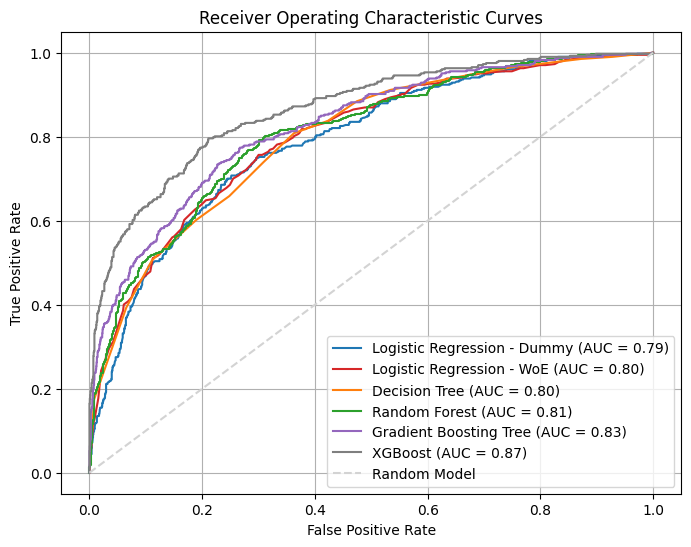

In [54]:
plot_roc_curve(models_dict, y_test)

In [55]:
summary = pd.DataFrame()
for model_name, model_details in models_dict.items():
    summary = pd.concat([summary, test_threshold(model_details[0], model_details[1], y_test, model_details[2]).rename(index={0: model_name})])
summary.sort_values(by='Weighted F1-score', ascending=False)

,Area Under Curve,Accuracy,Precision,Recall,F1-score,Weighted F1-score
XGBoost,0.8655,0.8645,0.7099,0.5651,0.6293,0.8585
Gradient Boosting Tree,0.8253,0.8420,0.6655,0.4496,0.5367,0.8299
Random Forest,0.8075,0.8320,0.6254,0.4349,0.5130,0.8201
Logistic Regression - WoE,0.7997,0.8295,0.6269,0.4005,0.4888,0.8145
Decision Tree,0.7982,0.8110,0.5379,0.5061,0.5215,0.8088
Logistic Regression - Dummy,0.7896,0.8150,0.5860,0.3096,0.4051,0.7917


Based on the Weighted F1-score evaluation metric the **XGBoost** model is the best classification model for predicting churn.

Notebook running time:

In [56]:
print(f'{round((time.time() - start_time)/60,4)} minutes.')

3.5216 minutes.
